#Context

this code was based on Tensorflows documentation for using an RNN for text sentiment analyisis and Google Colab pro copilot

The model was trained on Google colab pro using an A100 gpu and high memory mode for maximum training

https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [ ]:
import nltk
import keras
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import numpy as np
import re
from nltk.corpus import stopwords
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [ ]:

def remove_stopwords(text):
    # Use stop words from NLTK library
    stop_words = set(stopwords.words('english'))
    text = tf.strings.regex_replace(text, r'\b(' + '|'.join(stop_words) + r')\b', '')
    return text

def preprocess_pipeline(text, label):
    text = remove_stopwords(text)
    return text, label

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Preprocess
train_dataset = train_dataset.map(preprocess_pipeline)
test_dataset = test_dataset.map(preprocess_pipeline)

# Shuffling, batching, and prefetching
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRL6VIC/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRL6VIC/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRL6VIC/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
print(train_dataset)

for text, label in train_dataset:
  print(label)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
tf.Tensor(
[1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0
 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0], shape=(64,), dtype=int64)
tf.Tensor(
[0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0], shape=(64,), dtype=int64)
tf.Tensor(
[1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1], shape=(64,), dtype=int64)
tf.Tensor(
[0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0
 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 0], shape=(64,), dtype=int64)
tf.Tensor(
[1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0
 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1], shape=(64,), dtype=int64)
tf.Tensor(
[1

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())

print(vocab)

['' '[UNK]' 'i' ... 'plots' 'grown' 'creates']


## Googles RNN model

In [ ]:
model = keras.models.load_model('/content/RNN_model_sent_analysis.keras')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=15, validation_data=test_dataset,validation_steps=30)

Epoch 1/15
391/391 [==============================] - 41s 84ms/step - loss: 0.5860 - accuracy: 0.6251 - val_loss: 0.4949 - val_accuracy: 0.6792
Epoch 2/15
391/391 [==============================] - 19s 48ms/step - loss: 0.3684 - accuracy: 0.8366 - val_loss: 0.3367 - val_accuracy: 0.8615
Epoch 3/15
391/391 [==============================] - 18s 45ms/step - loss: 0.3024 - accuracy: 0.8737 - val_loss: 0.3192 - val_accuracy: 0.8703
Epoch 4/15
391/391 [==============================] - 17s 41ms/step - loss: 0.2777 - accuracy: 0.8856 - val_loss: 0.3102 - val_accuracy: 0.8635
Epoch 5/15
391/391 [==============================] - 17s 42ms/step - loss: 0.2669 - accuracy: 0.8880 - val_loss: 0.3055 - val_accuracy: 0.8703
Epoch 6/15
391/391 [==============================] - 17s 42ms/step - loss: 0.2584 - accuracy: 0.8939 - val_loss: 0.3135 - val_accuracy: 0.8729
Epoch 7/15
391/391 [==============================] - 17s 43ms/step - loss: 0.2520 - accuracy: 0.8984 - val_loss: 0.3315 - val_accuracy:

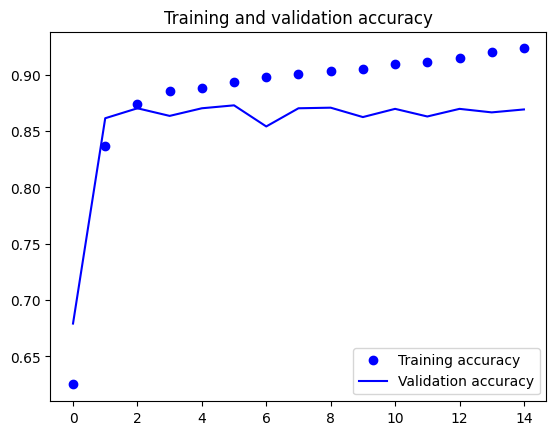

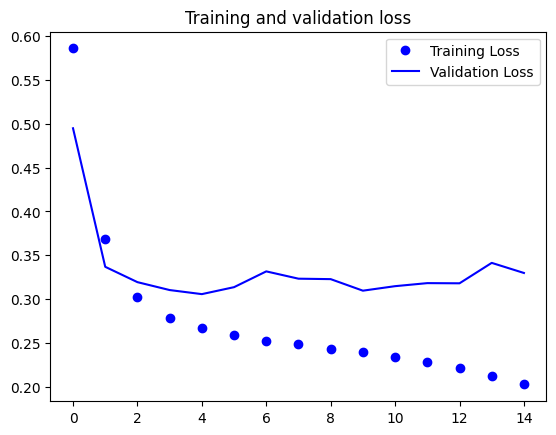

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(test_dataset)

391/391 [==============================] - 7s 17ms/step - loss: 0.3245 - accuracy: 0.8638


[0.32447361946105957, 0.8637599945068359]

In [ ]:
model.save('RNN_model_sent_analysis.keras')

### Testing

Test on sample text here

In [ ]:
def SentimentAnalysis(Text):
  pred = model.predict(np.array([Text]))
  if pred > 0.5:
    print('Very positive',pred[0][0])
  elif pred >0.2:
    print('Positive',pred[0][0])
  elif pred < 0.2 and pred >-0.2:
    print('Neutral',pred[0][0])
  elif pred < -0.5:
    print('Very Negative',pred[0][0])
  elif pred < -0.2:
    print('Negative',pred[0][0])

In [ ]:
SentimentAnalysis('Good')
SentimentAnalysis('Bad')
SentimentAnalysis('No comment')
SentimentAnalysis('I enjoy your service.')
SentimentAnalysis('I do not enjoy your service.')
SentimentAnalysis('I would recommend your service.')
SentimentAnalysis('I would not recommend your service.')
SentimentAnalysis('It could be worse')
SentimentAnalysis('It could be better')

1/1 [==============================] - 0s 21ms/step
Very positive 0.889704
1/1 [==============================] - 0s 18ms/step
Very Negative -1.482159
1/1 [==============================] - 0s 18ms/step
Very Negative -0.71698016
1/1 [==============================] - 0s 18ms/step
Very positive 1.3118523
1/1 [==============================] - 0s 18ms/step
Positive 0.44326627
1/1 [==============================] - 0s 17ms/step
Very Negative -0.6875912
1/1 [==============================] - 0s 17ms/step
Very Negative -1.5762961
1/1 [==============================] - 0s 17ms/step
Very Negative -2.4613512
1/1 [==============================] - 0s 17ms/step
Very Negative -1.0258511


In [ ]:
while True:
  validation_text = input('Type:')
  print(SentimentAnalysis(validation_text))

1/1 [==============================] - 0s 22ms/step
Very positive 4.5710654
None
1/1 [==============================] - 0s 21ms/step
Very Negative -3.922944
None
1/1 [==============================] - 0s 20ms/step
Very Negative -1.7541908
None
